In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import mtpplots
%matplotlib inline

data = pd.read_excel("/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/Standard Stars 2021_11_08 (1).xlsx")

data = data.dropna()

In [2]:
data

,Image name,AIRMASS,EXPOSURE,Filter,Star name/ID,B,V,R,B-V,V-R,Class (S/P),InstMag,Error
0,Std_92248-002R.fit,1.439128,60.0,R,92 248,16.474,15.346,14.656,1.128,0.690,S,-5.958,0.026
1,Std_92248-002R.fit,1.439128,60.0,R,92 249,15.024,14.325,13.926,0.699,0.399,P,-6.688,0.016
2,Std_92248-002R.fit,1.439128,60.0,R,92 250,13.992,13.178,12.732,0.814,0.446,P,-7.883,0.008
3,Std_92248-002R.fit,1.439128,60.0,R,92 330,15.641,15.073,14.742,0.568,0.331,P,-5.933,0.026
4,Std_92248-002R.fit,1.439128,60.0,R,92 252,15.449,14.932,14.606,0.517,0.326,P,-6.026,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Std_114750-001V,1.161280,20.0,V,114 654,11.833,0.656,0.178,0.368,0.341,S,-8.515,0.013
128,Std_114750-001V,1.161280,20.0,V,114 656,12.644,0.965,0.698,0.547,0.506,S,7.663,0.022
129,Std_114750-001B,1.160816,40.0,B,114 750,11.875,11.916,11.889,-0.041,0.027,P,-8.704,0.031
130,Std_114750-001B,1.160816,40.0,B,114 654,11.833,0.656,0.178,0.368,0.341,S,-8.224,0.040


<ErrorbarContainer object of 3 artists>

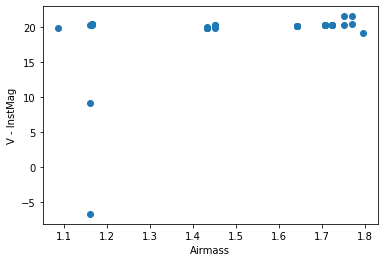

In [3]:
Vdata = data[data["Filter"]=='V']
Vx = Vdata["AIRMASS"]
Vy = Vdata['V']-Vdata["InstMag"]
Verr = Vdata["Error"]
plt.ylabel('V - InstMag')
plt.xlabel('Airmass')

plt.errorbar(Vx, Vy, yerr=Verr, fmt = "o")

<ErrorbarContainer object of 3 artists>

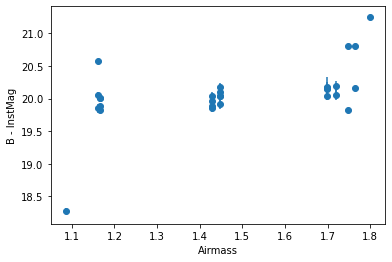

In [4]:
Bdata = data[data["Filter"]=='B']
Bx = Bdata["AIRMASS"]
By = Bdata['B'] - Bdata["InstMag"]
Berr = Bdata["Error"]
plt.ylabel('B - InstMag')
plt.xlabel('Airmass')

plt.errorbar(Bx, By, yerr=Berr, fmt = "o")

<ErrorbarContainer object of 3 artists>

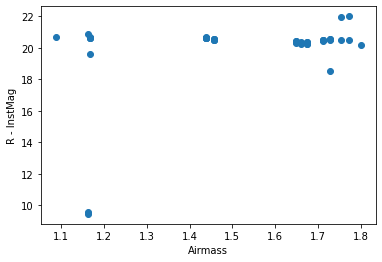

In [5]:
Rdata = data[data["Filter"]=='R']
Rx = Rdata["AIRMASS"]
Ry = Rdata['R'] - Rdata["InstMag"]
Rerr = Rdata["Error"]
plt.ylabel('R - InstMag')
plt.xlabel('Airmass')

plt.errorbar(Rx, Ry, yerr=Rerr, fmt = "o")

# Fitting V

In [6]:
import scipy.optimize as opt
import numpy as np
from IPython.display import display,Math

VmR = Vdata["V-R"]
def extt(X,k,Z,kp):
    airmass, VmR = X
    return Z + (k*airmass) + (kp*VmR*airmass)

s1p,s1cov = opt.curve_fit(extt,[Vx, 0*VmR],Vy, p0 = [1,-20,1], sigma = Verr)

print(s1p)
print(s1cov)

display(Math(r'$m=%7.4f\pm%7.4f$' % (s1p[0],np.sqrt(s1cov[0,0]))))
display(Math(r'$c=%7.4f\pm%7.4f$' % (s1p[1],np.sqrt(s1cov[1,1]))))

[7.04677791 8.66542664 1.        ]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Math object>

<IPython.core.display.Math object>

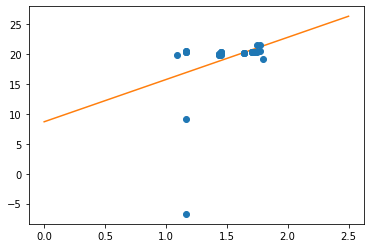

In [7]:
xs = np.linspace(0,2.5,1000)
plt.errorbar(Vx, Vy, yerr=Verr, fmt = "o")
plt.plot(xs, extt([xs,0*xs], *s1p))

In [8]:
import emcee

In [17]:
def ll1(par,x,y,yerr, color):
    m,c, kp = par
    model = (extt([x, color], m, c, kp))
    sigma2 = yerr**2
    return -0.5 * np.sum((y-model)**2/sigma2)

np.random.seed(42)
pos = np.array([7.0,8.5,0.5]) + 1.0e-4 * np.random.randn(32,3)
nwalkers, ndim = pos.shape

#Sample from the posterior distribution using emcee for 5000 steps with each walker
sampler = emcee.EnsembleSampler(nwalkers,ndim,ll1,args=(Vx,Vy,Verr,VmR))
sampler.run_mcmc(pos,5000,progress=True);


100%|██████████| 5000/5000 [09:47<00:00,  8.51it/s]


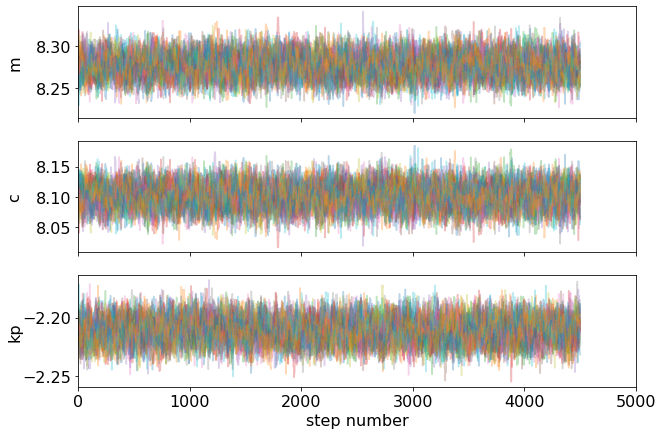

In [20]:
#Plot the chains for each parameter
plt.rcParams.update({'font.size': 16})
fig,axes = plt.subplots(3,figsize=(10,7),sharex=True)
samples = sampler.get_chain()
labels = ["m","c","kp"]
for i in range(ndim):
    ax = axes[i]
    for j in range(nwalkers):
        ax.plot(samples[500:,j,i],alpha=0.3)
    print(f"{label[i]} : {np.median}")
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number');

In [25]:
print(np.average(samples[500:],axis=1))
np.median(samples[500:],axis=1)
np.std(samples[500:],axis=1)

[[ 8.27525747  8.10109095 -2.20729657]
 [ 8.27544968  8.10096171 -2.20732777]
 [ 8.27383595  8.10350101 -2.20801897]
 ...
 [ 8.27212858  8.10570729 -2.20533806]
 [ 8.27294795  8.10437965 -2.20542859]
 [ 8.27264447  8.10502768 -2.20561171]]


array([[0.01368496, 0.02104734, 0.00834426],
       [0.01216842, 0.0188144 , 0.00732539],
       [0.0120405 , 0.01875132, 0.00773815],
       ...,
       [0.01436199, 0.02346498, 0.00908672],
       [0.01392769, 0.02281528, 0.00945203],
       [0.01304484, 0.02206548, 0.00973144]])

In [30]:
flat = sampler.get_chain(flat=1)

In [31]:
flat = flat[500:]

In [33]:
print(np.average(flat,axis = 0))
print(np.median(flat, axis=0))
print(np.std(flat, axis=0))

[ 8.25203157  8.120137   -2.17826363]
[ 8.27609865  8.10253911 -2.21063313]
[0.1717762  0.13484061 0.27165306]
